In [1]:
import symd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pickle
import pandas as pd
import skunk
import svglib
import seaborn as sns

In [2]:
base_colors = ["f94144","f3722c","f8961e","f9844a","f9c74f","90be6d","43aa8b","4d908e","577590","277da1"]    
colors = ['#' + c for c in base_colors]
sns.set_style("white")
sns.set_style("ticks")
sns.set(rc={'axes.facecolor':'#f5f4e9', 
            'grid.color' : '#AAAAAA', 
            'axes.edgecolor':'#333333', 
            'figure.facecolor':'#FFFFFF', 
            'axes.grid': False,
            'axes.prop_cycle':   plt.cycler('color', plt.cm.Dark2.colors),
            'font.family': 'monospace'
           })
print(symd.__version__)

0.2.1


In [13]:
def run_sim(n, number_density, group, w=None, retries=5, pos_frames=0, steps=30000):
    for _ in range(retries):
        try:
            cell = symd.groups.get_cell(number_density, group, 3, n, w)
            md = symd.Symd(nparticles=n, cell=cell, ndims=3, images=2, force='lj', wyckoffs=w,
              group=group, steps=steps, exeDir='sim2d', start_temperature=0.5)
            md.remove_overlap()
            if pos_frames > 0:
                md.log_positions(frames=pos_frames)
            md.log_output(period = int(1 / md.runParams['time_step']))
            md.run()
            break
        except RuntimeError as e:
            print(e)
            md = None
    return md

In [4]:
np.random.seed(0)
md = run_sim(5, 0.2, 17, pos_frames=100)

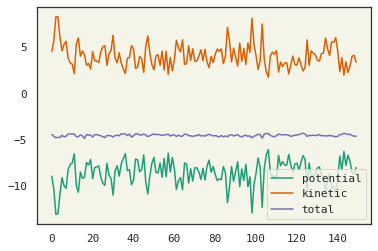

In [5]:
plt.plot(md.pe, label='potential')
plt.plot(md.ke, label='kinetic')
plt.plot(md.te, label='total')
plt.legend(loc='best')

## All Sims

In [9]:
titles = [str(i) for i in range(1,231,14)]
df = pd.DataFrame()
retries = 3
def standardize(te):
    i = int(md.te.shape[0] * 0.2)
    te = md.te[i:]
    return te - np.mean(te)

In [10]:
for i,t in enumerate(titles):    
    md = run_sim(4, 0.2, i+1)
    df = df.assign(**{t: standardize(md.te)})    

{"steps": 1000, "n_particles": 4, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "sim2d/group-6.dat", "cell_log_file": "sim2d/cell_log_file.dat", "print_period": 300.0, "cell": [2.15444, 0.0, 0.0, 0.0, 2.15444, 0.0, 0.0, 0.0, 2.15444], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "sim2d/group-6.dat", "group": "sim2d/group-6.json"}
Info: You are running version 9075-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-6 with 4 particles and 2 members
Info: Duplicating 4 particles into 4 real particles and 996 ghost for group with 2 elements and 124 tilings. Each cell has 8 particles.
Info: Computed 12 degrees of freedom
        Step         Time            T     

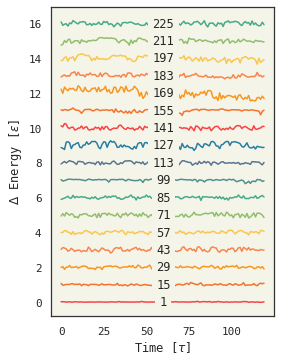

In [11]:
fig = plt.figure(figsize=(4,5.7))
ax = plt.gca()
mx = df.shape[0] // 2
for i,n in enumerate(df.columns):
    color = colors[i % len(base_colors)]
    ax.plot(df[n] + i, color=color)
    offsetbox = mpl.offsetbox.TextArea(n)
    ab = mpl.offsetbox.AnnotationBbox(offsetbox, (mx,i),
                    xybox=(mx,i),
                    xycoords='data',
                    boxcoords='data',
                    arrowprops=None,
                    bboxprops=dict(fc="#f5f4e9", lw=0))
    ax.add_artist(ab)
ax.set_xlabel(r'Time [$\tau$]')
ax.set_facecolor('#f5f4e9')
ax.set_ylabel(r'$\Delta$ Energy [$\epsilon$]')
plt.savefig('energy3d.svg')

## Movie

In [114]:
import moviepy.editor as editor
from moviepy.video.io.bindings import mplfig_to_npimage

def limit(traj, lim=(-5,5)):
    out = np.copy(traj)
    imin = out < lim[0]
    imax = out > lim[1]
    # set elements outside of range as nan
    out[imin] = np.nan
    out[imax] = np.nan
    # set particles with one nan element as all nan
    inan = np.any(np.isnan(out), axis=-1)
    out[inan, :] = np.nan
    return out

def plot_traj(traj, P, M, title, color='#333333', fps=60):
    T, N, D = traj.shape        
    fps = fps
    duration = T / fps
    dpi = 90
    fig = plt.figure(figsize=(1200 / dpi, 800 / dpi), dpi=dpi)
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    tc = [np.random.choice(colors) for _ in range(P)] * (M // P)
    traj2 = limit(traj, (-8,8))
    points1 = [ax1.scatter(traj[0,:M,0], traj[0,:M,1], traj[0,:M,2], 
                          color=tc,
                          marker='o', s=250, linewidths=1, edgecolors='#999')]
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    points2 = ax2.plot(traj2[0,:,0], traj2[0,:,1], traj2[0,:,2], c=color, mec='#999', marker='o',                        
                        linestyle='None', markersize=4)[0]
    ax2.set_facecolor('#f5f4e9')
    ax1.set_facecolor('#f5f4e9')
    fig.patch.set_facecolor('#f5f4e9')
    ax1.set_title('Unit Cell', fontsize=32, color='#333333',fontname='monospace')
    ax2.set_title(title, fontsize=32, color='#333333',fontname='monospace')
    ax1.axis('off')
    ax2.axis('off')
    xlim = ax1.get_xlim()
    ylim = ax1.get_ylim()
    zlim = ax1.get_zlim()
    xlim2 = ax2.get_xlim()
    ylim2 = ax2.get_ylim()
    zlim2 = ax2.get_zlim()
    angle = 60
    plt.tight_layout()
    def make_frame(t):
        i = int(t  * fps)
        i = max(0, min(i, T-1))
        points1[0].remove()
        points1[0] = ax1.scatter(traj[i,:M,0], traj[i,:M,1], traj[i,:M,2], 
                          color=tc,
                          marker='o', s=250, linewidths=1, edgecolors='#999')
        points2.set_data_3d(traj2[i,:,0], traj2[i,:,1], traj2[i,:,2])    
        #ax1.view_init(30, (angle + t * 3) % 360)
        #ax2.view_init(30, (angle + t * 3) % 360)
        ax1.set_xlim(*xlim)
        ax1.set_ylim(*ylim)
        ax1.set_zlim(*zlim)
        ax2.set_xlim(*xlim2)
        ax2.set_ylim(*ylim2)
        ax2.set_zlim(*zlim2)
        plt.draw()
        return mplfig_to_npimage(fig)

    return editor.VideoClip(make_frame, duration=duration)
def write_video(clips, output, fps=60, transition=0.25):
    composite = editor.concatenate(clips[:1] + [c.crossfadein(transition) for c in clips[1:]], 
                                   padding=-transition, method='compose')   
    composite.write_videofile(output, fps=fps, preset='slower', ffmpeg_params=['-tune', 'animation'])
    
def run_nvesim(n, number_density, group, w=None, retries=5, pos_frames=0, steps=30000):
    for _ in range(retries):
        try:
            cell = symd.groups.get_cell(number_density, group, 3, n, w)
            md = symd.Symd(nparticles=n, cell=cell, ndims=3, images=2, force='lj', wyckoffs=w,
              group=group, steps=steps, exeDir='sim3d', start_temperature=0.2, temperature=None, pressure=None)
            md.remove_overlap()
            if pos_frames > 0:
                md.log_positions(frames=pos_frames)
            md.run()
            break
        except RuntimeError as e:
            print(e)
            md = None
    return md


                                                                                                                                                                                                                                                                                     
t:  24%|██████████████████████████████████████████████████████                                                                                                                                                                                | 20/85 [12:58<00:05, 12.43it/s, now=None]
                                                                                                                                                                                                                                                                                     
t:  24%|██████████████████████████████████████████████████████                                                                                                    

Moviepy - Building video 3d.mp4.
Moviepy - Writing video 3d.mp4



                                                                                                                                                                                                                                                                                        
                                                                                                                                                                                                                                                                                     
t:  24%|██████████████████████████████████████████████████████                                                                                                                                                                                | 20/85 [13:02<00:05, 12.43it/s, now=None]
                                                                                                                                                                

Moviepy - Done !
Moviepy - video ready 3d.mp4


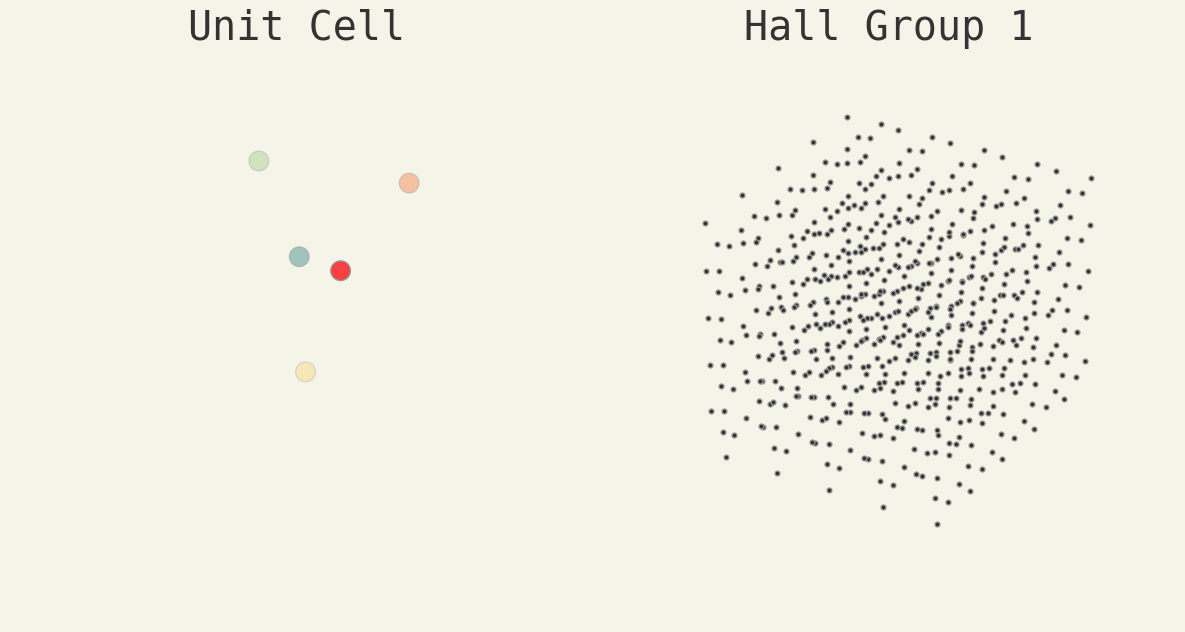

In [116]:
md = run_nvesim(5, 0.3, 1, pos_frames=100, steps=500)
c = plot_traj(md.positions, md.nparticles, md.cell_nparticles, title='Hall Group 1')
write_video([c], '3d.mp4')

In [117]:
md.runParams

{'steps': 500,
 'n_particles': 5,
 'time_step': 0.005,
 'seed': 435423,
 'anderson_nu': 100,
 'langevin_gamma': 0.1,
 'bussi_taut': 0.5,
 'thermostat_seed': 54344,
 'rcut': 10,
 'skin': 0.6000000000000001,
 'temperature': 0,
 'pressure': None,
 'box_update_period': 0,
 'start_temperature': 0.2,
 'thermostat': None,
 'force_type': 'lj',
 'final_positions': 'sim3d/final_positions.dat',
 'cell_log_file': 'sim3d/cell_log_file.dat',
 'print_period': 5.0,
 'cell': [2.55436, 0.0, 0.0, 0.0, 2.55436, 0.0, 0.0, 0.0, 2.55436],
 'lj_epsilon': 1,
 'lj_sigma': 1,
 'n_images': 2,
 'start_positions': 'sim3d/final_positions.dat',
 'group': 'sim3d/group-1.json',
 'position_log_period': 5,
 'positions_log_file': 'sim3d/positions.xyz'}